In [24]:
import os, shutil
import cv2
import zipfile

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
def zipdir(src_path: str, zip_file: zipfile.ZipFile):
    ''' add dirctory with relative path to the zip archive

    Args:
      src_path: path to the directory
      zip_file: zip archive
    '''
    for root, dirs, files in os.walk(src_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, src_path)
            zip_file.write(file_path, arcname)

def archive_directory(src_dir: str, dst_file: str):
    ''' archive directory

    Args:
      src_dir: path to the directory
      dst_file: name of the archive
    '''
    with zipfile.ZipFile(dst_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipdir(src_dir, zipf)

In [3]:
USE_COLAB = False


MODEL_NAME = 'HandMadeGrayscale'
SEED = 42
image_size = (224, 224)
batch_size = 32

In [4]:
try:
    import google.colab
    from google.colab import drive
    USE_COLAB = True
except ImportError:
    USE_COLAB = False

In [5]:
dataset_dir = os.path.join('../', 'data', 'SmallPreprocessed')

if USE_COLAB:
    drive.mount('/content/drive')
    filename = 'smallpreprocessed.zip'

    dest_path = f'{filename}_extracted'
    shutil.rmtree(dest_path, ignore_errors=True)

    with zipfile.ZipFile( os.path.join('/content/drive/MyDrive', filename), 'r') as zip_ref:
        zip_ref.extractall(dest_path)


    dataset_dir = os.path.join('/content/', dest_path, 'data', 'SmallPreprocessed')

Mounted at /content/drive


In [25]:
def convert_to_grayscale(image):
    image = image[..., ::-1]
    return tf.image.rgb_to_grayscale(image)


In [26]:
datagen = ImageDataGenerator(
    preprocessing_function= convert_to_grayscale,
    rescale=1./255
)

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

Found 12000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [27]:
class_num = list(train_generator.class_indices.keys())
class_num

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [28]:
model = keras.models.Sequential()

model.add(Input(shape=(image_size[0], image_size[1], 3)))

model.add(Conv2D(32, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed=SEED))

model.add(Dense(len(class_num), activation="softmax"))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 221, 221, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 70, 70, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 20, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,020,260 (3.89 MB)

 Trainable params: 1,020,260 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
checkpoint_cb = ModelCheckpoint(
    f"model_{MODEL_NAME}_checkpoint.keras",
    save_best_only = True)

early_stopping_cb = EarlyStopping(
    patience = 10,
    restore_best_weights = True
)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [14]:
EPOCHS = 20

In [30]:
hist = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = [checkpoint_cb, early_stopping_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 194ms/step - accuracy: 0.3575 - loss: 1.2695 - val_accuracy: 0.6495 - val_loss: 0.7371
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 192ms/step - accuracy: 0.6819 - loss: 0.6919 - val_accuracy: 0.7370 - val_loss: 0.5804
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.7682 - loss: 0.5234 - val_accuracy: 0.7950 - val_loss: 0.4822
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 190ms/step - accuracy: 0.8200 - loss: 0.4042 - val_accuracy: 0.8120 - val_loss: 0.4154
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.8630 - loss: 0.3240 - val_accuracy: 0.8780 - val_loss: 0.2972
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - accuracy: 0.9041 - loss: 0.2340 - val_accuracy: 0.8825 - val_loss: 0.3025
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 188ms/step - accuracy: 0.9360 - loss: 0.1692 - val_accuracy: 0.9145 - val_loss: 0.2307
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.9459 - loss: 0

In [31]:
if USE_COLAB:
    model_dir = os.path.join('/content/', 'models')
    zip_name = os.path.join('/content/', f'{MODEL_NAME}_model.zip')
    gdrive_file = os.path.join('/content/drive/MyDrive/', f'{MODEL_NAME}_model.zip')

    os.makedirs(model_dir, exist_ok=True)

    model.save(os.path.join(model_dir, f'{MODEL_NAME}_model.keras'))
    model.export(os.path.join(model_dir, MODEL_NAME))
    archive_directory(model_dir, zip_name)

    if os.path.exists(zip_name):
        os.remove(zip_name)

    archive_directory(model_dir, zip_name)

    shutil.copyfile(zip_name, gdrive_file)

    shutil.rmtree(model_dir, ignore_errors=True)
    os.remove(zip_name)

    print(f"model data was stored on google drive as {gdrive_file}")
else:
    model.save(f'../models/{MODEL_NAME}_model.keras')
    model.export(f'../models/{MODEL_NAME}_model')


Saved artifact at '/content/models/HandMadeGrayscale'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_134')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139850440934224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139850440934800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139850440934416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139850440935952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139850440935568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139850440936720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139850440936336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139850440937488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139850440937296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139850440938448: TensorSpec(shape=(), dtype=tf.resource, name=N

In [32]:
score, acc= model.evaluate(test_generator)
print('Val Loss =', score)
print('Val Accuracy =', acc)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9462 - loss: 0.1599
Val Loss = 0.20299620926380157
Val Accuracy = 0.9279999732971191


In [33]:
hist_=pd.DataFrame(hist.history)

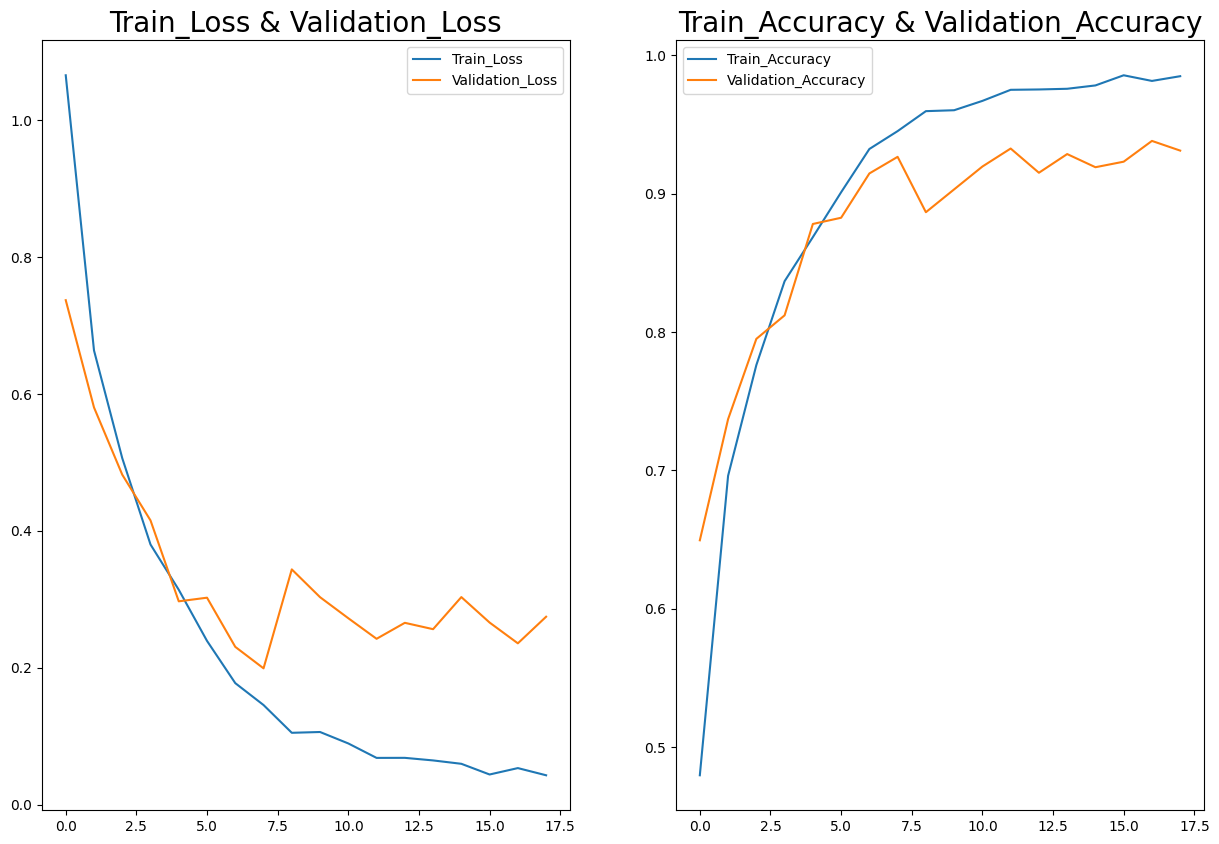

In [34]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [35]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step


array([[470,   4,   8,  18],
       [  0, 500,   0,   0],
       [  8,   0, 465,  27],
       [ 33,   1,  45, 421]])

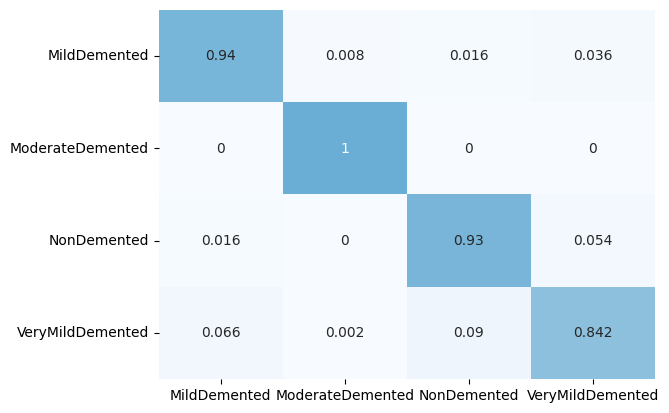

In [36]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [37]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
                   precision    recall  f1-score   support

    MildDemented       0.92      0.94      0.93       500
ModerateDemented       0.99      1.00      1.00       500
     NonDemented       0.90      0.93      0.91       500
VeryMildDemented       0.90      0.84      0.87       500

        accuracy                           0.93      2000
       macro avg       0.93      0.93      0.93      2000
    weighted avg       0.93      0.93      0.93      2000

